In [26]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [30]:
# Load all CSV files from performance_metrics folder
reports_dir = "classification_reports"
csv_files = [f for f in os.listdir(reports_dir) if f.endswith('_report.csv')]

# Dictionary to store all model reports
model_reports = {}

# Load each CSV file
for csv_file in csv_files:
    model_name = csv_file.replace('_report.csv', '')
    file_path = os.path.join(reports_dir, csv_file)
    df = pd.read_csv(file_path, index_col=0)
    model_reports[model_name] = df

print(f"Loaded {len(model_reports)} models: {', '.join(model_reports.keys())}")

Loaded 7 models: ann, lgbm, xgb, knn, catboost, svc, rf


In [31]:
print("\n" + "="*70)
print("COMPARISON TABLE: Models vs Metrics")
print("="*70)

# Extract weighted average metrics for each model
comparison_data = []
for model_name, df in model_reports.items():
    # Get accuracy (it's in the 'accuracy' row, under 'f1-score' column)
    accuracy = df.loc['accuracy', 'f1-score'] if 'accuracy' in df.index else 0
    
    # Get weighted average metrics
    if 'weighted avg' in df.index:
        weighted_row = df.loc['weighted avg']
        comparison_data.append({
            'Model': model_name.upper(),
            'Accuracy': round(accuracy, 4),
            'Precision': round(weighted_row['precision'], 4),
            'Recall': round(weighted_row['recall'], 4),
            'F1-Score': round(weighted_row['f1-score'], 4)
        })

# Create main comparison DataFrame
main_comparison_df = pd.DataFrame(comparison_data)
main_comparison_df = main_comparison_df.sort_values('Accuracy', ascending=False)

# Display as a table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
print(main_comparison_df.to_string(index=False))


COMPARISON TABLE: Models vs Metrics
 Model    Accuracy  Precision  Recall  F1-Score
     KNN   0.9900    0.9902    0.9900   0.9900 
    LGBM   0.9844    0.9845    0.9844   0.9844 
CATBOOST   0.9756    0.9760    0.9756   0.9757 
     XGB   0.9750    0.9753    0.9750   0.9750 
     ANN   0.9694    0.9698    0.9694   0.9694 
      RF   0.9644    0.9646    0.9644   0.9644 
     SVC   0.9081    0.9112    0.9081   0.9082 


In [32]:
print("\n" + "="*70)
print("PER-CLASS COMPARISON TABLES")
print("="*70)

# Get all class labels (excluding special rows)
all_classes = []
for df in model_reports.values():
    classes = [idx for idx in df.index if idx not in ['accuracy', 'macro avg', 'weighted avg']]
    for cls in classes:
        if cls not in all_classes:
            all_classes.append(cls)

all_classes = sorted(all_classes)

# Create DataFrames for each metric
for metric in ['precision', 'recall', 'f1-score']:
    print(f"\n📋 {metric.upper()} by Class:")
    print("-"*60)
    
    # Create DataFrame for this metric
    metric_df = pd.DataFrame(index=all_classes)
    
    # Fill with values from each model
    for model_name, df in model_reports.items():
        metric_values = []
        for class_label in all_classes:
            if class_label in df.index:
                metric_values.append(round(df.loc[class_label, metric], 4))
            else:
                metric_values.append(None)
        metric_df[model_name.upper()] = metric_values
    
    # Display as table
    print(metric_df.to_string())
    print()  # Empty line between tables


PER-CLASS COMPARISON TABLES

📋 PRECISION by Class:
------------------------------------------------------------
     ANN    LGBM     XGB     KNN   CATBOOST    SVC     RF  
0  1.0000  1.0000  1.0000  1.0000   1.0000   1.0000  0.9976
1  0.9811  0.9946  0.9891  1.0000   0.9891   0.9611  0.9755
2  0.9615  0.9726  0.9530  0.9899   0.9439   0.8115  0.9407
3  0.9349  0.9703  0.9580  0.9707   0.9699   0.8685  0.9428


📋 RECALL by Class:
------------------------------------------------------------
     ANN    LGBM     XGB     KNN   CATBOOST    SVC     RF  
0  1.0000  0.9976  0.9976  0.9929   1.0000   0.9976  0.9976
1  0.9578  0.9736  0.9578  0.9815   0.9551   0.9129  0.9472
2  0.9446  0.9824  0.9698  0.9874   0.9748   0.9219  0.9597
3  0.9724  0.9825  0.9724  0.9975   0.9699   0.7945  0.9499


📋 F1-SCORE by Class:
------------------------------------------------------------
     ANN    LGBM     XGB     KNN   CATBOOST    SVC     RF  
0  1.0000  0.9988  0.9988  0.9965   1.0000   0.9988  0.9976
1


VISUAL COMPARISON CHARTS


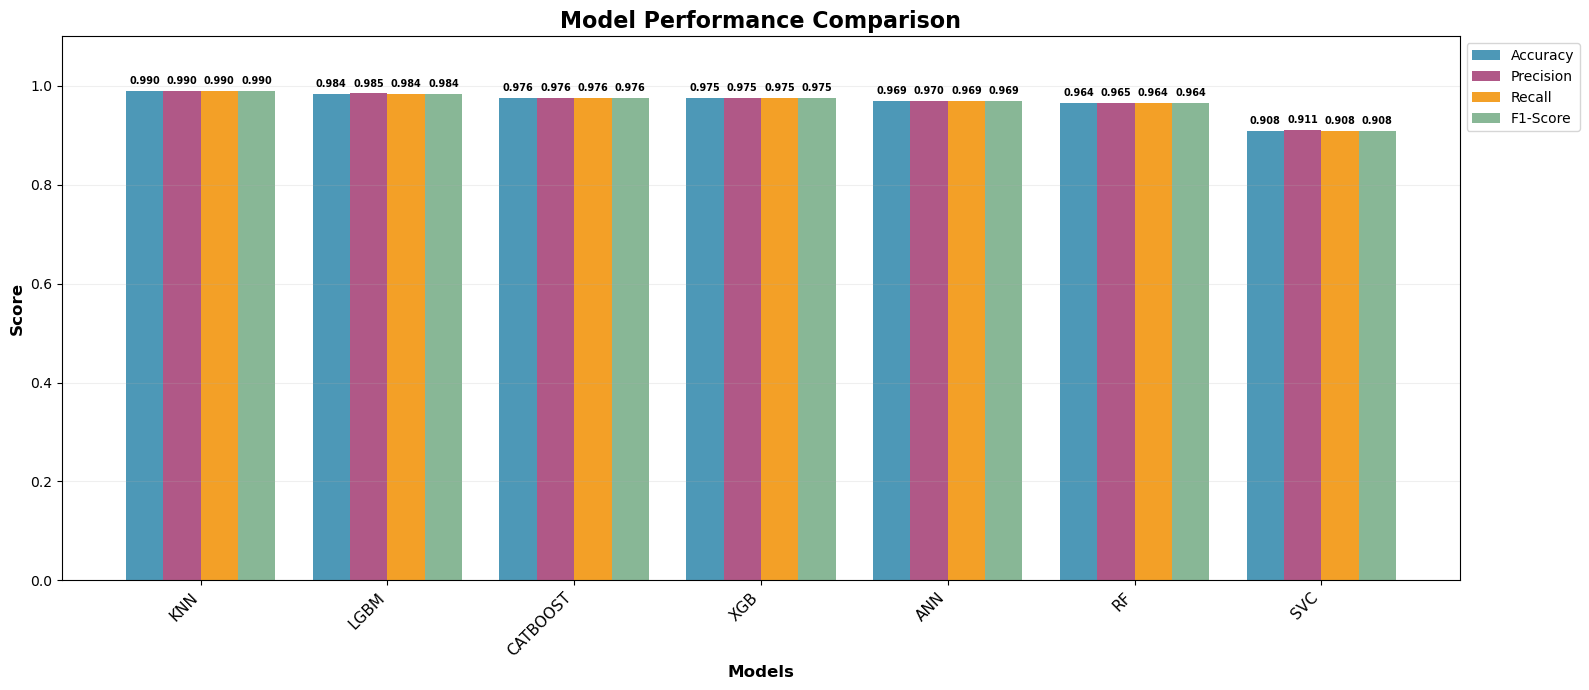

In [33]:
print("\n" + "="*70)
print("VISUAL COMPARISON CHARTS")
print("="*70)

# Prepare data for plotting
plot_df = main_comparison_df.set_index('Model')

# Create wider bar chart
fig, ax = plt.subplots(figsize=(16, 7))

# Set bar positions
n_models = len(plot_df)
x = range(n_models)
bar_width = 0.2

# Plot each metric
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#73AB84']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    values = plot_df[metric].values
    bars = ax.bar([pos + i * bar_width for pos in x], values, 
                 bar_width, label=metric, color=color, alpha=0.85)
    
    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{value:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# Customize chart
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks([pos + 1.5 * bar_width for pos in x])
ax.set_xticklabels(plot_df.index, rotation=45, ha='right', fontsize=11)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.2, axis='y')

plt.tight_layout()
plt.show()

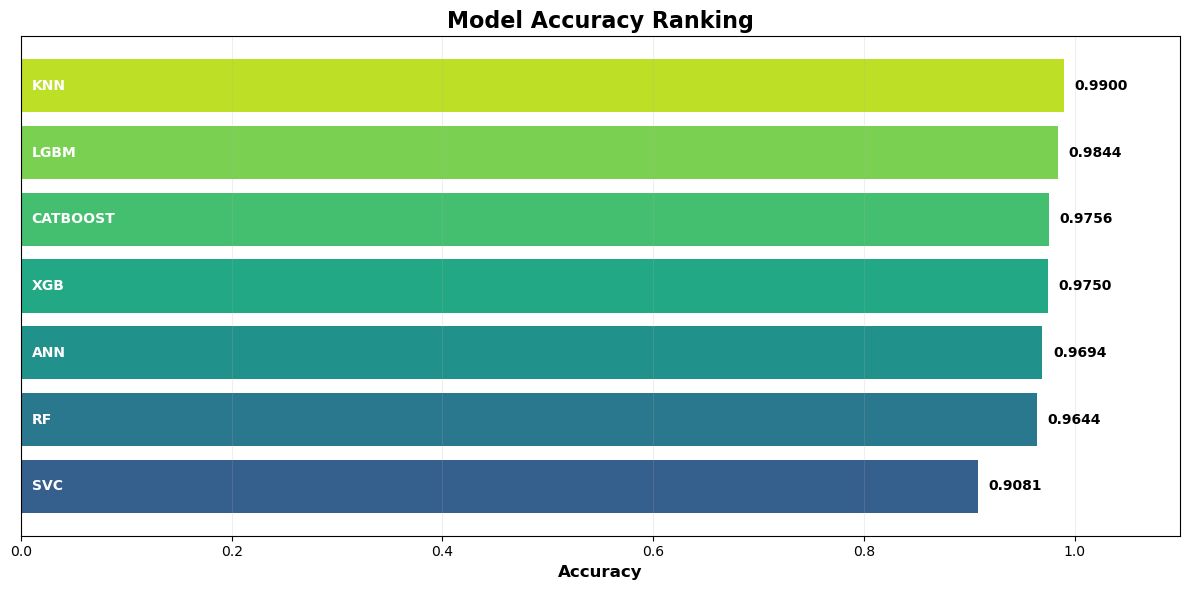


Analysis complete! Main table saved as 'model_comparison_summary.csv'


In [35]:
fig2, ax2 = plt.subplots(figsize=(12, 6))

# Sort by accuracy
accuracy_sorted = plot_df.sort_values('Accuracy')

# Create horizontal bar chart
bars2 = ax2.barh(range(len(accuracy_sorted)), accuracy_sorted['Accuracy'], 
                color=plt.cm.viridis(np.linspace(0.3, 0.9, len(accuracy_sorted))))

# Remove y-axis numbers
ax2.set_yticks([])

# Add model names and values inside bars
for i, (bar, (model_name, row)) in enumerate(zip(bars2, accuracy_sorted.iterrows())):
    # Add rank and model name
    ax2.text(0.01, bar.get_y() + bar.get_height()/2,
            f"{model_name}", 
            va='center', ha='left', color='white', fontweight='bold')
    
    # Add accuracy value
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{row["Accuracy"]:.4f}', va='center', ha='left', fontweight='bold')

# Customize
ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Model Accuracy Ranking', fontsize=16, fontweight='bold')
ax2.set_xlim(0, 1.1)
ax2.grid(True, alpha=0.2, axis='x')

plt.tight_layout()
plt.show()

# Save results
main_comparison_df.to_csv('model_comparison_summary.csv', index=False)
print("\nAnalysis complete! Main table saved as 'model_comparison_summary.csv'")